## Q. 기상 실측 데이터를 토대로 태양광 발전량인 amount(2023-10-15) 값을 예측해보시오.

In [ ]:
# 구글드라이브 마운트

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
from torch.utils.data import TensorDataset, DataLoader

pd.set_option('display.max_column', 20)
pd.set_option('display.max_row', 100)

data = pd.read_csv('/content/drive/MyDrive/tobigs/정규세션/5주차/energy_tobigs_question.csv')
data['time'] = pd.to_datetime(data['time'])

# 피처와 타겟 변수 설정
features = ['cloud', 'temp', 'humidity', 'wind_speed', 'wind_dir', 'rain', 'snow','vis', 'uv_idx', 'azimuth']
target = 'amount'

# 데이터셋 분리 (2023-10-14까지 학습, 2023-10-15 하루 예측)
train_data = data[data['time'] < '2023-10-15'].copy()
test_data = data[(data['time'] >= '2023-10-15') & (data['time'] < '2023-10-16')].copy()

# 학습 데이터에 NaN 값 제거
train_data = train_data.dropna()

# 데이터 스케일링
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

train_data.loc[:, features] = scaler_x.fit_transform(train_data[features])
train_data.loc[:, target] = scaler_y.fit_transform(train_data[[target]])

test_data.loc[:, features] = scaler_x.transform(test_data[features])
test_data.loc[:, target] = scaler_y.transform(test_data[[target]])

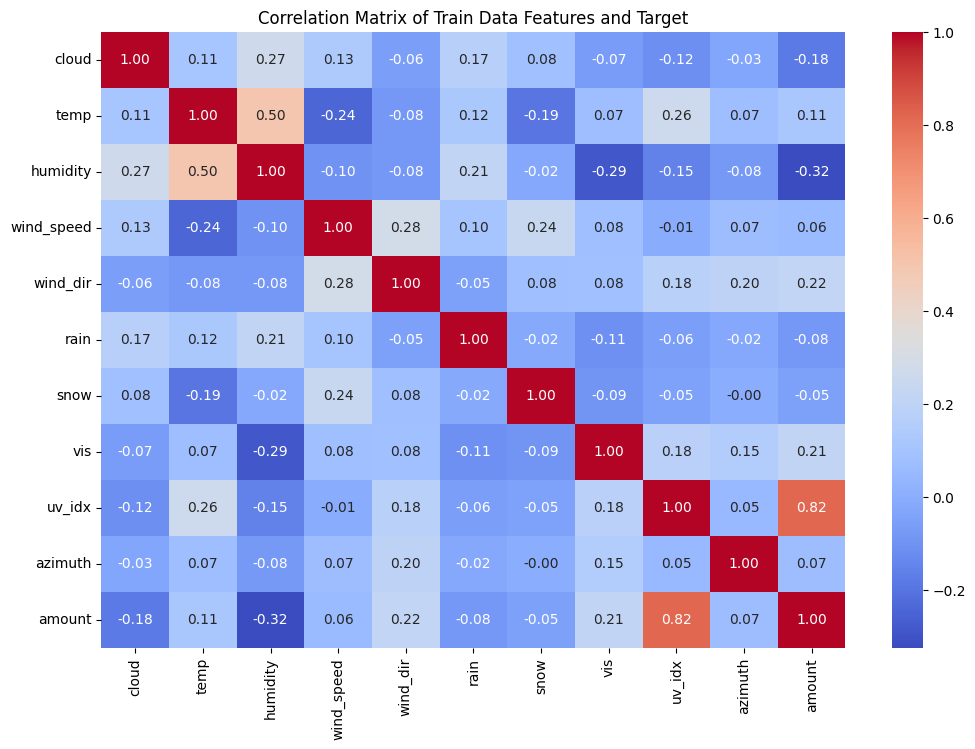

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터셋 (train_data)을 불러왔다는 가정 하에 상관행렬 계산 및 시각화
correlation_matrix = train_data[features + [target]].corr()

# 상관관계 행렬 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Train Data Features and Target')
plt.show()

### 시퀀스 데이터 생성 함수 작성

In [ ]:
# 텐서로 변환해서 텐서데이터셋을 생성하세요. (1~6 번에 내용을 채워보세요.)

# 시퀀스 데이터 생성 함수
# dataX: 시퀀스 데이터를 담은 리스트 (예: [[시퀀스1], [시퀀스2], ...])
# dataY: 각 시퀀스에 대응하는 타겟 값 (예: 발전량)

def build_dataset(time_series, seq_length):
    dataX, dataY = [], []
    for i in range(len(time_series) - seq_length):
        dataX.append(time_series[i:i+seq_length, :-1])
        dataY.append(time_series[i+seq_length, [-1]])
    return np.array(dataX), np.array(dataY)

# 하이퍼파라미터 설정
seq_length = 24
batch_size = 64

# 학습 데이터 생성
# trainX: 24시간의 피처 데이터
# trainY: 그 다음 시간에 대한 발전량 값
trainX, trainY = build_dataset(train_data[features + [target]].values, seq_length)

# 텐서로 변환
trainX_tensor = torch.tensor(trainX, dtype=torch.float32)
trainY_tensor = torch.tensor(trainY, dtype=torch.float32)

# 텐서데이터셋 생성
train_dataset = TensorDataset(trainX_tensor, trainY_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

### 학습한 시계열 모델을 사용해서 예측을 해보세요 (RNN, LSTM, Transformer, Informer 중에서 선택적으로 활용)

In [ ]:
!pip install --upgrade 'u8darts[all]'


In [ ]:
# 슬라이딩 윈도우 방식으로 2023-10-15의 24시간 발전량 예측해보기 (Direct Multi-step Forecast Strategy 혹은 Recursive Multi-step Forecast 등 이외의 방법론도 자유롭게 사용 가능)

from darts import TimeSeries
import pandas as pd

# 시간대 제거
train_data['time'] = train_data['time'].dt.tz_localize(None)
test_data['time'] = test_data['time'].dt.tz_localize(None)

# 이미 스케일링된 데이터를 TimeSeries로 변환
train_series = TimeSeries.from_dataframe(train_data, 'time', target)
test_series = TimeSeries.from_dataframe(test_data, 'time', target)
train_covariates = TimeSeries.from_dataframe(train_data, 'time', features)
test_covariates = TimeSeries.from_dataframe(test_data, 'time', features)

# Train의 마지막 시점과 Test의 첫 시점이 연속적인지 확인
train_end_time = train_covariates.time_index[-1]
test_start_time = test_covariates.time_index[0]

if train_end_time + pd.Timedelta(hours=1) == test_start_time:
    # 연속된 시계열 데이터를 결합
    test_covariates_extended = train_covariates.append(test_covariates)
else:
    raise ValueError("Train and Test covariates are not continuous.")



In [ ]:
from darts.models import TransformerModel

# Transformer 모델 초기화
model = TransformerModel(input_chunk_length=24, output_chunk_length=24, n_epochs=100, batch_size=32, dropout=0.1)

# 모델 학습
model.fit(train_series, past_covariates=train_covariates)

# 2023-10-15 하루의 발전량 예측
predictions = model.predict(n=24, past_covariates=test_covariates_extended)


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RAN

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# 예측 결과를 스케일 복원
predicted_values = predictions.pd_series().values  # 예측 결과를 NumPy로 변환
predicted_amounts = scaler_y.inverse_transform(predicted_values.reshape(-1, 1))
predicted_amounts = np.maximum(predicted_amounts, 0)  # 음수 값을 0으로 고정
predicted_amounts = predicted_amounts.flatten()

# 예측 결과 출력
print(predicted_amounts)


[ 0.          0.          0.14086311  0.7703388   0.93469069  0.87501124
  1.53611317  1.17936291  9.56896739 27.88925893 54.51887901 74.44355468
 83.05273702 83.69262414 82.48238708 73.59865781 53.89154533 28.37170585
  8.12777782  0.          0.          0.          0.5637611   2.05295118]


### 2023-10-15 발전량 예측값을 predicted_amounts에 저장하고 시각화를 실행해주세요.

In [ ]:
# 시각화
fig = go.Figure()

# 실제 발전량 시각화
fig.add_trace(go.Scatter(x=data['time'], y=data['amount'],
                         mode='lines', name='Actual Amount'))

# 예측된 발전량 시각화 (2023-10-15의 24시간 동안의 예측)
fig.add_trace(go.Scatter(x=test_data['time'], y=predicted_amounts,
                         mode='lines', name='Predicted Amount', line=dict(dash='dot', color='red')))

# 레이아웃 설정
fig.update_layout(title='2023-10-15 24시간 발전량 예측',
                  xaxis_title='시간',
                  yaxis_title='발전량 (kWh)'
                  )

# 그래프 출력
fig.show()

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



### 정답을 적어주세요.

In [ ]:
# 예측된 24시간 발전량 출력
print(f'2023-10-15 예측 발전량 (24시간): {predicted_amounts} kWh')

2023-10-15 예측 발전량 (24시간): [ 0.          0.          0.14086311  0.7703388   0.93469069  0.87501124
  1.53611317  1.17936291  9.56896739 27.88925893 54.51887901 74.44355468
 83.05273702 83.69262414 82.48238708 73.59865781 53.89154533 28.37170585
  8.12777782  0.          0.          0.          0.5637611   2.05295118] kWh


---

### (필수) Informer모델은 transformer 모델의 어떤 부분을 개선하고자 했나요? (차이점을 중심으로 서술)

In [ ]:
'''
informer 모델은 기존 transformer 모델의 계산 효율성과 메모리 문제를 해결하기 위해 등장한 개선 모델이다.

transformer 모델의 경우 O(N^2)의 시간 복잡도(N: 쿼리와 키 행렬의 행 개수)와
O(J*N^2)의 메모리 사용량(J: layer의 총 개수, N: 쿼리와 키 행렬의 행 개수)를 가졌다.
또, 다이나믹 디코딩 방식을 사용하기 때문에 speed plunge 문제가 있었다.

Informer는 transformer의 이런 부분을 개선하고자 했다.
probsparse self-attention(쿼리 벡터 중 일부만을 선발하여 self-attention을 진행)을 사용했다.
transformer 모델에서 쿼리와 키를 곱한 것 중 많은 정보를 가지고 있는 것이 소수에 불과하기 때문에 샘플링해도 정보의 손실이 크지 않다.
쿼리를 뽑는 방식은 각 쿼리 행에 대해 내적 값을 확률분포표로 나타내고, 이러한 쿼리 벡터 중 sparse한 U개의 벡터를 선택한다.
(정확히는 0에 가까운 값이 많은 벡터, 즉 sparse한 쿼리는 높은 attention score를 가진 query일 확률이 높다고 봄. 높은 attention score는 큰 정보량을 의미한다.)

sparsity를 판단하는 기준 -> KL - divergence

또, 메모리 병목 현상을 해결하기 위해
인코더에서는 1D consolution과 Max Pooling을 이요앟여 데이터의 시간 축을 절반으로 압축하는 self-attention distilling을 사용한다.
디코더에서는 masked self attention을 예측 과정에서 사용하는 generatice inference를 사용한다.
다이나믹 디코딩 방식과 다르게 병렬 계산이 가능하기 때문에 speed plunge 문제를 해결할 수 있다.
'''

### (필수) 모델링 해석

In [ ]:
# 모델을 선택했다면 왜 선택했는지 본인만의 근거를 정리해주세요.
# 더 나아가 파라미터 선택의 기준이 있었다면 좋습니다.
'''
transformer를 사용한 이유는 데이터가 긴 시퀀스를 가지고 있기 때문에
RNN 계열 모델보다 데이터를 더 효과적으로 학습할 수 있다고 생각했기 때문이다.
'''

### (선택) 데이터 해석

In [ ]:
# 데이터셋을 보고 느낀 생각이나 본인만의 논리 전개 방식을 정리해주세요.
# 전처리를 했다면 해당 전처리를 왜 했는지, 파생변수를 생성했다면 왜 만들었는지 등
'''
transformer 모델을 사용해서 다중공선성이 매우 치명적이진 않겠지만,
영향을 끼칠 가능성은 높다고 생각했기 때문에 상관관계 행렬을 시각화하고
피쳐들끼리의 상관관계가 심한 것들은 제거했다.
'''
